In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
import stlstuff as sls
import imagestuff as ims
import abel

import copy 
import os
import time
from sys import platform
from scipy.interpolate import griddata
import retrievestuff
import Fourier_Filter;
#import importlib; importlib.reload(Fourier_Filter)

#import f90nml

In [2]:
%matplotlib notebook

In [3]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [4]:
#Iwantsyntheticdata = False
Iwantsyntheticdata = True

if Iwantsyntheticdata:
    
    # Load a height file (for synthetic data)
    sollast = np.loadtxt("Fri Mar  1 14_36_55 2019"+slash+"surface.txt")
    sollast = sollast - np.mean(sollast)
    Ny, Nx = np.shape(sollast); #print(sollast.shape) #print(Nx,Ny)
    Lx = 30; Ly = 31

    # Getting the x,y grids
    x = np.linspace(0,Lx,Nx); dx = x[1]-x[0]
    y = np.linspace(0,Ly,Ny); dy = y[1]-y[0]
    xgrid,ygrid = np.meshgrid(x,y); #print(xgrid.shape)

else:
    # Load the height file (for real data)
    npzfile = np.load("Case2.1"+slash+"Segmentsretrieved.npz")
    nx1list = npzfile['nx1list']
    nx2list = npzfile['nx2list']
    ny1list = npzfile['ny1list']
    ny2list = npzfile['ny2list']
    solution = npzfile['solution']
    nsegments = len(nx1list)
    accumlist = [5]
    sollast = get_heights(\
                  nsegments,nx1list,nx2list,ny1list,ny2list,dx,dy,solution,\
                  accumlist)


In [5]:
# Plot the surface as a mesh
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, sollast)
ax.set_xlabel('x')
ax.set_ylabel('y')

<IPython.core.display.Javascript object>

Text(0.5,0,'y')

PolarImage (107, 151)
k: (107,)
theta (151,)


<IPython.core.display.Javascript object>


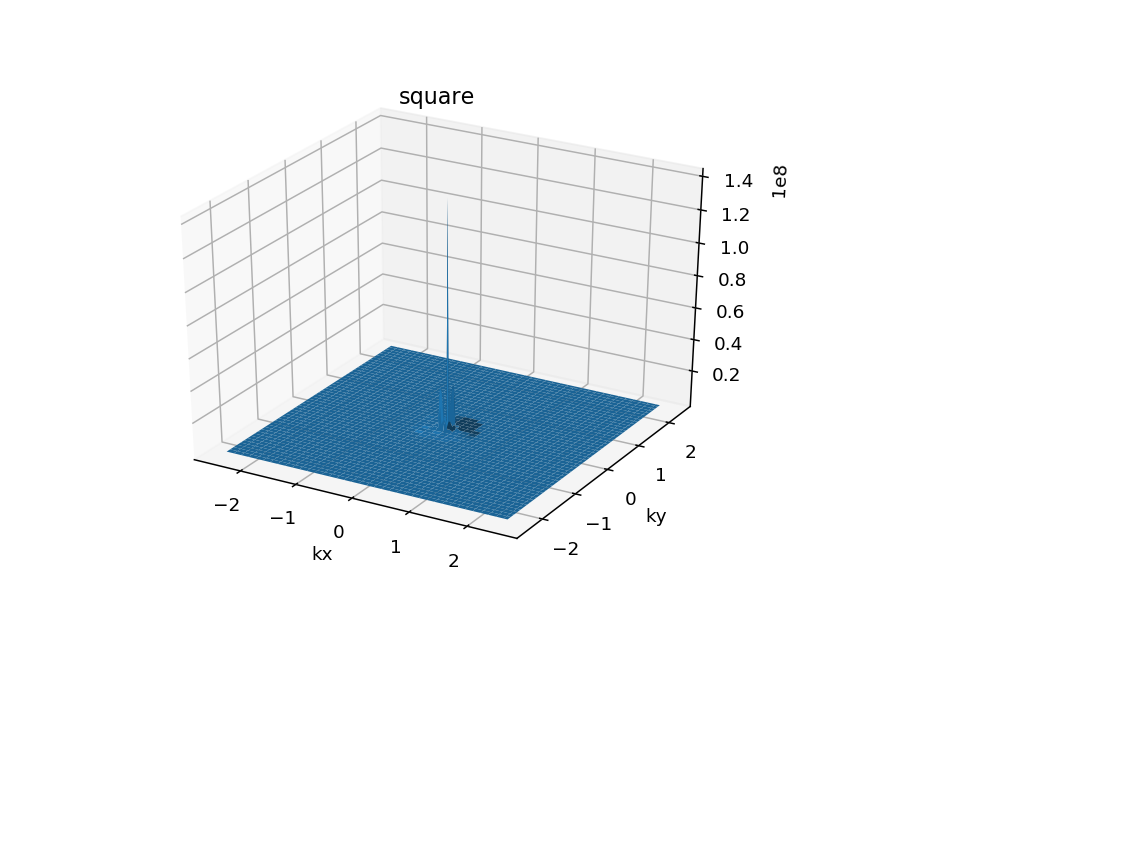

<IPython.core.display.Javascript object>


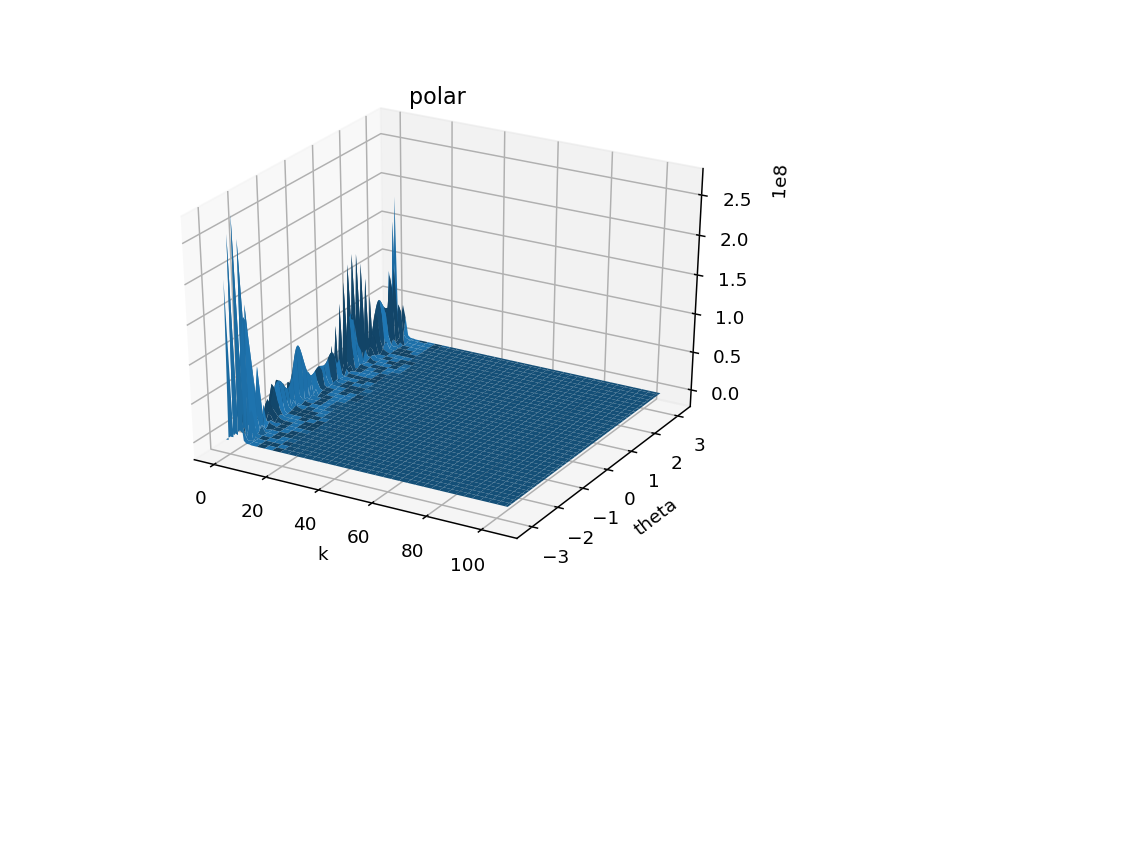

Text(0.5,0.92,'polar')

In [16]:
# Fourier transform it
sollast_FTshift,kxshift,kyshift = Fourier_Filter.FT(sollast,x,y)

# This makes gridded versions of the k-arrays
kxshiftgrid,kyshiftgrid = np.meshgrid(kxshift,kyshift);

# Find the aboslute square
sollast_FTshift_square = np.real(sollast_FTshift)**2 +  np.imag(sollast_FTshift)**2 

# Project onto polar coordinates
PolarImage, k_grid, theta_grid = abel.tools.polar.reproject_image_into_polar(sollast_FTshift_square, Jacobian = True)
print('PolarImage', np.shape(PolarImage))
k = k_grid[:,0]; print('k:', np.shape(k))
theta = theta_grid[0,:]; print('theta', np.shape(theta))

# Plot various parts of the FT
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(kxshiftgrid, kyshiftgrid, np.real(sollast_FTshift))
# ax.set_xlabel('kx')
# ax.set_ylabel('ky')
# ax.set_title('real')

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(kxshiftgrid, kyshiftgrid, np.imag(sollast_FTshift))
# ax.set_xlabel('kx')
# ax.set_ylabel('ky')
# ax.set_title('imag')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kxshiftgrid, kyshiftgrid, sollast_FTshift_square)
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_title('square')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(k_grid, theta_grid, PolarImage)
ax.set_xlabel('k')
ax.set_ylabel('theta')
ax.set_title('polar')

<IPython.core.display.Javascript object>


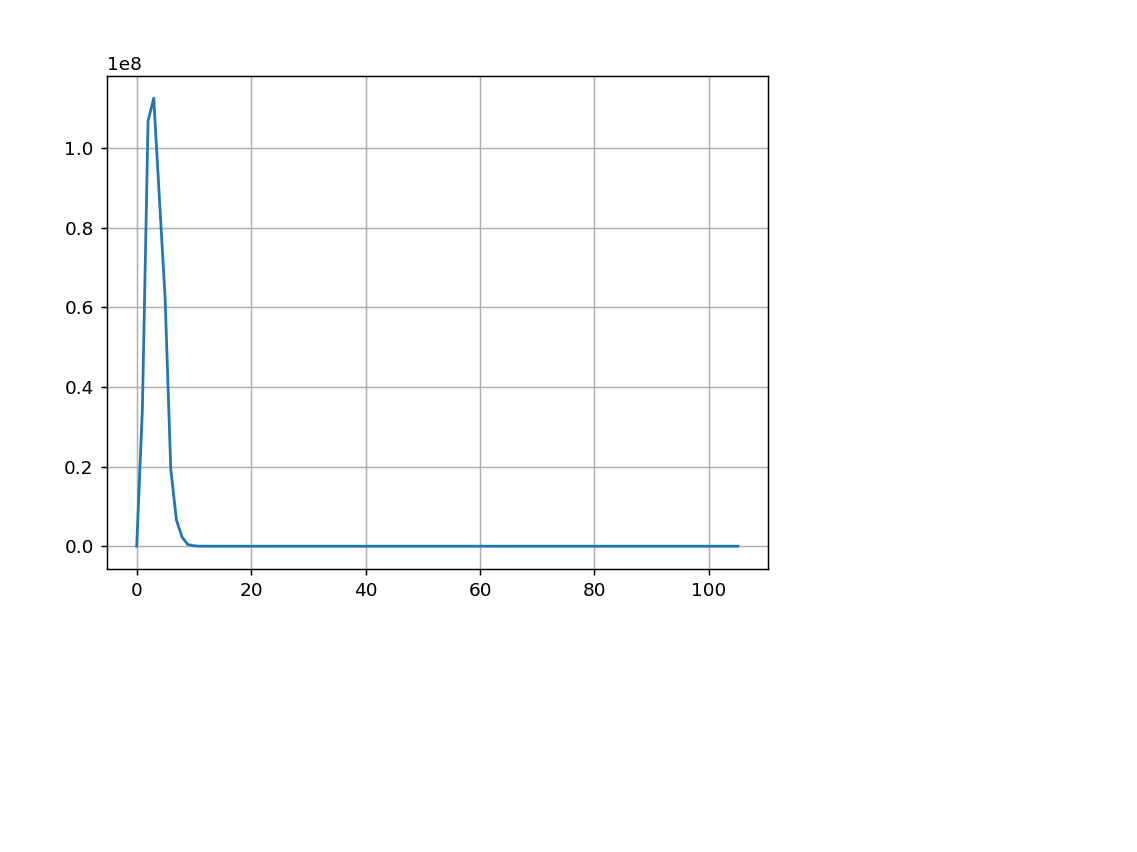

In [27]:
Fofk = np.trapz(PolarImage*k_grid,theta,axis=1)/(np.pi*2)
plt.figure()
plt.plot(k,Fofk)
plt.grid(True)

In [ ]:
# First make a copy of the Fourier representation
sollast_FTshift_filtered = sollast_FTshift*1

# Apply a mask
kmax = 1.5
for ix in range(Nx):
    for iy in range(Ny):
        ktest = np.sqrt(kxshiftgrid[iy,ix]**2+kyshiftgrid[iy,ix]**2)
        if(ktest>kmax):
            sollast_FTshift_filtered[iy,ix]=0

In [ ]:
# Inverse FT
sollast_FT_filtered_IFT = Fourier_Filter.IFT(sollast_FTshift_filtered)

# Plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, np.real(sollast_FT_filtered_IFT))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('real')

# Plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, np.real(sollast_FT_filtered_IFT-sollast))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('real difference')

# Plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, np.imag(sollast_FT_filtered_IFT))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('imag')